# 🧠 Deep Reinforcement Learning — Doom Agent (SS2025)

Welcome to the last assignment for the **Deep Reinforcement Learning** course (SS2025). In this notebook, you'll implement and train a reinforcement learning agent to play **Doom**.

You will:
- Set up a custom VizDoom environment with shaped rewards
- Train an agent using an approach of your choice
- Track reward components across episodes
- Evaluate the best model
- Visualize performance with replays and GIFs
- Export the trained agent to ONNX to submit to the evaluation server

In [3]:
# Clone repo
not_cloned = True
if not_cloned:
    !git clone https://$token@github.com/gerkone/jku.wad.git
    %cd jku.wad

C:\Users\Benjamin\Documents\GitHub\DRL_DOOM\jku.wad


Cloning into 'jku.wad'...


In [2]:
# Install the dependencies
dependencies_not_installed = False
if dependencies_not_installed:
    !pip install torch numpy matplotlib vizdoom portpicker gym onnx
    !pip install onnxruntime

In [90]:
from typing import Dict, Sequence, Tuple

import torch
from collections import deque, OrderedDict
import collections
from copy import deepcopy
import random
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from gym import Env
from torch import nn
from einops import rearrange

from doom_arena import VizdoomMPEnv
from doom_arena.reward import VizDoomReward
from doom_arena.render import render_episode
from IPython.display import HTML
from vizdoom import ScreenFormat

## Environment configuration

ViZDoom supports multiple visual buffers that can be used as input for training agents. Each buffer provides different information about the game environment, as seen from left to right:


Screen
- The default first-person RGB view seen by the agent.

Labels
- A semantic map where each pixel is tagged with an object ID (e.g., enemy, item, wall).

Depth
- A grayscale map showing the distance from the agent to surfaces in the scene.

Automap
- A top-down schematic view of the map, useful for global navigation tasks.

![buffers gif](https://vizdoom.farama.org/_images/vizdoom-demo.gif)

In [91]:
USE_GRAYSCALE = False # ← flip to False for RGB

PLAYER_CONFIG = {
    "n_stack_frames": 1,
    "extra_state": ["depth"],
    "hud": "none",
    "crosshair": True,
    "screen_format": "ScreenFormat.GRAY8" if USE_GRAYSCALE else "ScreenFormat.CRCGCB"
}

In [92]:
# TODO: environment training paramters
N_STACK_FRAMES = 1
NUM_BOTS = 4
EPISODE_TIMEOUT = 1000

SCREEN_WIDTH = 120
SCREEN_HEIGHT = 90
SCREEN_CHANNELS = 3 if not USE_GRAYSCALE else 1
EXTRA_STATE = ["depth"]
HUD = "none"
CROSSHAIR = True
SCREEN_FORMAT = ScreenFormat.CRCGCB if not USE_GRAYSCALE else ScreenFormat.GRAY8
ACTION_SPACE = 7
OBSERVATION_SPACE = (SCREEN_CHANNELS * N_STACK_FRAMES, SCREEN_HEIGHT, SCREEN_WIDTH)

# TODO: model hyperparams
GAMMA = 0.95
# EPISODES = 100
EPISODES = 3
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 10000
LEARNING_RATE = 1e-4
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
N_EPOCHS = 50

## Reward function
In this task, you will define a reward function to guide the agent's learning. The function is called at every step and receives the current and previous game variables (e.g., number of frags, hits taken, health).

Your goal is to combine these into a meaningful reward, encouraging desirable behavior, such as:

- Rewarding frags (enemy kills)

- Rewarding accuracy (hitting enemies)

- Penalizing damage taken

- (Optional) Encouraging survival, ammo efficiency, etc.

You can return multiple reward components, which are summed during training. Consider the class below as a great starting point!

In [93]:
# ---------------------------------------------------------------
# 🥇 reward function
# ---------------------------------------------------------------

class YourReward(VizDoomReward):
    def __init__(self, num_players: int):
        super().__init__(num_players)

    def __call__(
        self,
        vizdoom_reward: float,
        game_var: Dict[str, float],
        game_var_old: Dict[str, float],
        player_id: int,
    ) -> Tuple[float, float, float]:
        """
        Custom reward function used by both training and evaluation.
        *  +100  for every new frag
        *  +2    for every hit landed
        *  -0.1  for every hit taken
        """
        self._step += 1
        _ = vizdoom_reward, player_id  # unused

        rwd_hit        =  2.0  * (game_var["HITCOUNT"]   - game_var_old["HITCOUNT"])
        rwd_hit_taken  = -0.1  * (game_var["HITS_TAKEN"] - game_var_old["HITS_TAKEN"])
        rwd_frag       = 100.0 * (game_var["FRAGCOUNT"]  - game_var_old["FRAGCOUNT"])

        return rwd_hit, rwd_hit_taken, rwd_frag


In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [95]:
DTYPE = torch.float32

reward_fn = YourReward(num_players=1)

env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="ROOM",  # NOTE simple, small map; other options: TRNM, TRNMBIG
    extra_state=PLAYER_CONFIG["extra_state"], # see info about states at the beginning of 'Environment configuration' above
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"],
    reward_fn=reward_fn,
)

Host 44401
Player 44401


## Agent

Implement **your own agent** in the code cell that follows.

* In `agents/dqn.py` and `agents/ppo.py` you’ll find very small **skeletons**—they compile but are meant only as reference or quick tests.  
  Feel free to open them, borrow ideas, extend them, or ignore them entirely.
* The notebook does **not** import those files automatically; whatever class you define in the next cell is the one that will be trained.
* You may keep the DQN interface, switch to PPO, or try something else.
* Tweak any hyper-parameters (`PLAYER_CONFIG`, ε-schedule, optimiser, etc.) and document what you tried.


In [96]:
# ================================================================
# DQN — design your network here
# ================================================================

class DQN(nn.Module):
    """
    Deep-Q Network template.

    Expected behaviour
    ------------------
    forward(frame)      # frame: (B, C, H, W)  →  Q-values: (B, num_actions)

    What to add / change
    --------------------
    • Replace the two `NotImplementedError` lines.
    • Build an encoder (Conv2d / Conv3d) + a head (MLP or duelling).
    • Feel free to use residual blocks from `agents/utils.py` or any design you like.
    """

    def __init__(self, input_dim: int, action_space: int, hidden: int = 128):
        # super().__init__()

        # # -------- TODO: define your layers ------------------------
        # # Example (very small) baseline — delete or improve:
        # #
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(input_dim, 32, 8, stride=4), nn.ReLU(),
        #     nn.Conv2d(32, 64, 4, stride=2),       nn.ReLU(),
        #     nn.Conv2d(64, 64, 3, stride=1),       nn.ReLU(),
        # )
        # self.head = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(64 * 7 * 7, hidden), nn.ReLU(),
        #     nn.Linear(hidden, action_space),
        # )
        super().__init__()

        # -------- TODO: define your layers ------------------------
        # Example (very small) baseline — delete or improve:
        #
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 32, 8, stride=4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),       nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),       nn.ReLU(),
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, hidden), nn.ReLU(),
            nn.Linear(hidden, action_space),
        )
        # -----------------------------------------------------------

    def forward(self, frame: torch.Tensor) -> torch.Tensor:
        # -------- TODO: implement forward -------------------------
        x = self.encoder(frame)
        x = self.head(x)
        return x
        # -----------------------------------------------------------


In [97]:
# ================================================================
# Initialise your networks and training utilities
# ================================================================

# main Q-network
in_channels = env.observation_space.shape[0]   # 1 if grayscale, else 3/4
model = DQN(
    input_dim    = in_channels,
    action_space = env.action_space.n,
    hidden       = 64,   # change or ignore
).to(device, dtype=DTYPE)

# TODO ------------------------------------------------------------
# 1. Create a target network (hard-copy or EMA)
# 2. Choose an optimiser + learning-rate schedule
# 3. Instantiate a replay buffer and set the initial epsilon value
#
# Hints:
model_tgt  = deepcopy(model).to(device)
optimizer  = torch.optim.Adam(model_tgt.parameters(), lr=LEARNING_RATE)
scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=GAMMA)
replay_buffer = collections.deque(maxlen=REPLAY_BUFFER_SIZE)
# ---------------------------------------------------------------


In [98]:
# ---------------------------------------------------------------
# 🔧 stolen utils from dqn.py
# ---------------------------------------------------------------

@torch.no_grad
def epsilon_greedy(
    env: Env,
    model: nn.Module,
    obs: torch.Tensor,
    epsilon: float,
    device: torch.device,
    dtype: torch.dtype,
):
    if random.random() < epsilon:
        return env.action_space.sample()
    else:
        obs = obs.to(device, dtype=dtype).unsqueeze(0)
        return model(obs).argmax().item()


@torch.no_grad()
def update_ema(ema_model, model, decay: float = 0.995):
    """Exponential moving average model updates."""
    ema_params = OrderedDict(ema_model.named_parameters())
    if hasattr(model, "module"):
        model_params = OrderedDict(model.module.named_parameters())
    else:
        model_params = OrderedDict(model.named_parameters())

    for name, param in model_params.items():
        ema_params[name].mul_(decay).add_(param.data, alpha=1 - decay)

epsilon = 0.995

## Training loop

In [99]:
# ---------------------  TRAINING LOOP  ----------------------
# Feel free to change EVERYTHING below:
#   • choose your own reward function
#   • track different episode statistics in `ep_metrics`
#   • switch optimiser, scheduler, update rules, etc.

reward_list, q_loss_list = [], []
best_eval_return, best_model = float("-inf"), None

for episode in range(EPISODES):
    ep_metrics = {"custom_reward": 0.0}     # ← add or replace keys as you like
    obs        = env.reset()[0]
    done, ep_return = False, 0.0
    model.eval()

    # ───────── rollout ─────────────────────────────────────────────
    while not done:
        act = epsilon_greedy(env, model, obs, epsilon, device, DTYPE)
        next_obs, rwd_raw, done, _ = env.step(act)

        # ----- reward definition (EDIT here) ----------------
        custom_rwd = float(rwd_raw[0])      # default: raw env reward
        # Example: access game variables for more detailed reward engineering
        # gv, gv_pre = env.envs[0].unwrapped._game_vars, env.envs[0].unwrapped._game_vars_pre
        # custom_rwd = your_function(gv, gv_pre)

        ep_metrics["custom_reward"] += custom_rwd

        replay_buffer.append((obs, act, custom_rwd, next_obs[0], done))
        obs, ep_return = next_obs[0], ep_return + custom_rwd
    reward_list.append(ep_return)

    # ───────── learning step (experience replay) ──────────────────
    if len(replay_buffer) >= BATCH_SIZE:
        model.train()
        for _ in range(N_EPOCHS):
            batch = random.sample(replay_buffer, BATCH_SIZE)
            s, a, r, s2, d = zip(*batch)

            s   = torch.stack(s).to(device, dtype=DTYPE)
            s2  = torch.stack(s2).to(device, dtype=DTYPE)
            a   = torch.tensor(a , device=device)
            r   = torch.tensor(r , device=device, dtype=torch.float32)
            d   = torch.tensor(d , device=device, dtype=torch.float32)

            q    = model(s).gather(1, a.unsqueeze(1)).squeeze(1)
            with torch.no_grad():
                q2 = model_tgt(s2).max(1).values
                tgt = r + GAMMA * q2 * (1 - d)
            loss = F.mse_loss(q, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            q_loss_list.append(loss.item())
        update_ema(model_tgt, model)

    scheduler.step()
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
    print(f"Ep {episode+1:03}: return {ep_return:6.1f}  |  ε {epsilon:.3f}")

    # ───────── quick evaluation for best-model tracking ───────────
    eval_obs, done, eval_return = env.reset()[0], False, 0.0
    model.eval()
    while not done:
        act = epsilon_greedy(env, model, eval_obs, 0.05, device, DTYPE)
        eval_obs_n, r, done, _ = env.step(act)
        eval_obs = eval_obs_n[0]
        eval_return += r[0]
    if eval_return > best_eval_return:
        best_eval_return, best_model = eval_return, deepcopy(model)

# ---------------------  SAVE / EXPORT ---------------------------------------
final_model = best_model if best_model is not None else model          # choose best


Ep 001: return   -0.1  |  ε 0.990
Ep 002: return   -0.4  |  ε 0.985
Ep 003: return   -0.3  |  ε 0.980


## Dump to ONNX

In [100]:
# ---------------------------------------------------------------
# 🧭 model save
# ---------------------------------------------------------------

import onnx
import json


def onnx_dump(env, model, config, filename: str):
    # dummy state
    init_state = env.reset()[0].unsqueeze(0)


    # Export to ONNX
    torch.onnx.export(
        model.cpu(),
        args=init_state,
        f=filename,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    )
    onnx_model = onnx.load(filename)

    meta = onnx_model.metadata_props.add()
    meta.key = "config"
    meta.value = json.dumps(config)

    onnx.save(onnx_model, filename)

onnx_dump(env, final_model, PLAYER_CONFIG, filename="model.onnx")
print("Best network exported to doom_dqn_best.onnx")

Best network exported to doom_dqn_best.onnx


### Evaluation and Visualization

In this final section, you can evaluate your trained agent, inspect its performance visually, and analyze reward components over time.


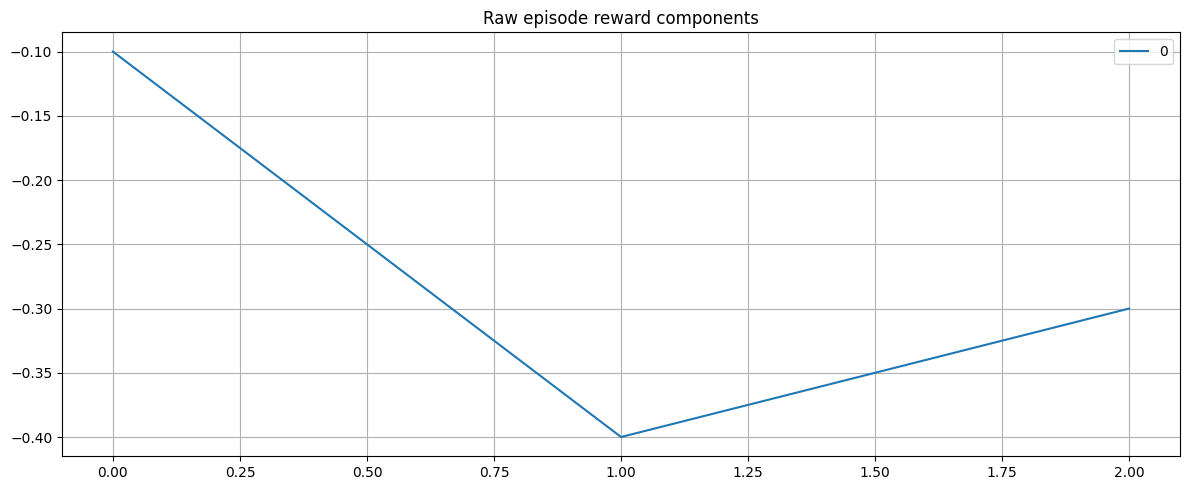

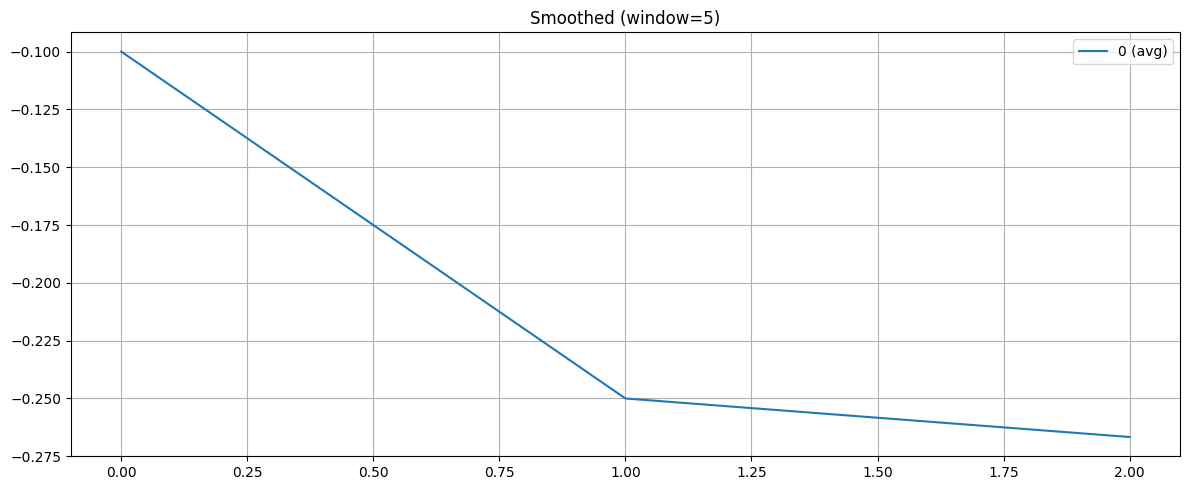

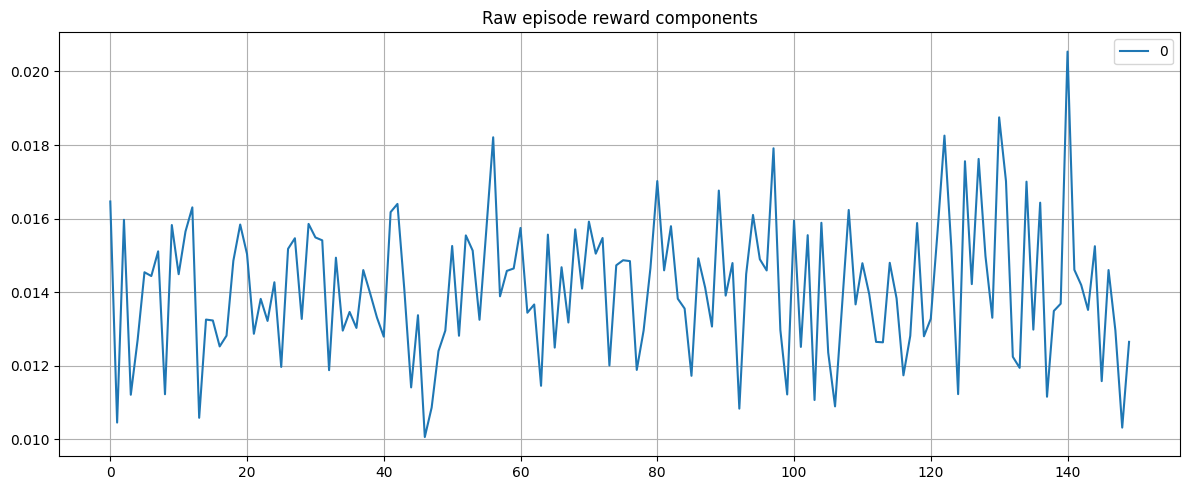

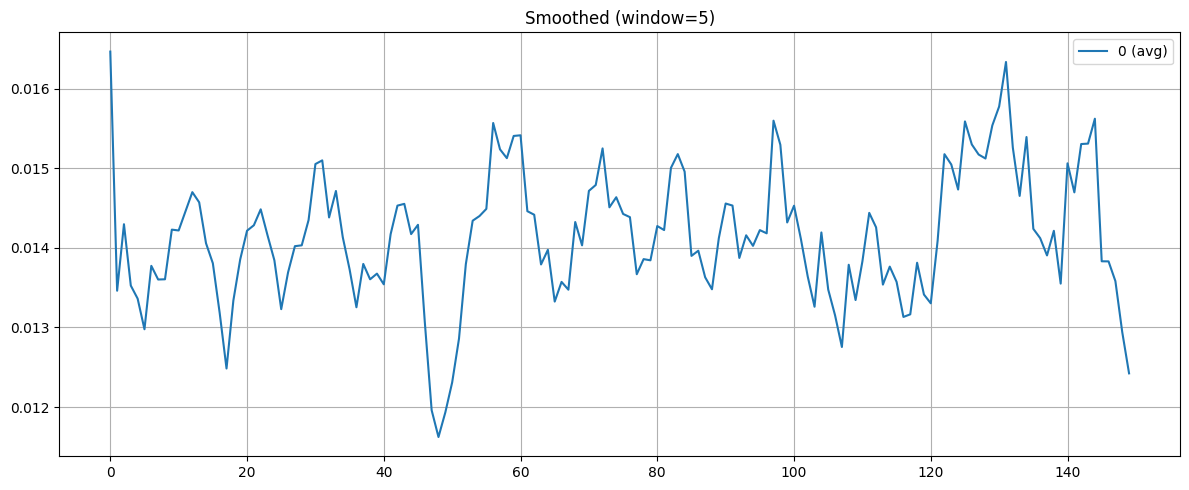

In [101]:
# ---------------------------------------------------------------
# 📈  Reward-plot helper  (feel free to edit / extend)
# ---------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

def plot_reward_components(reward_log, smooth_window: int = 5):
    """
    Plot raw and smoothed episode-level reward components.

    Parameters
    ----------
    reward_log : list[dict]
        Append a dict for each episode, e.g. {"frag": …, "hit": …, "hittaken": …}
    smooth_window : int
        Rolling-mean window size for the smoothed curve.
    """
    if not reward_log:
        print("reward_log is empty – nothing to plot.")
        return

    df = pd.DataFrame(reward_log)
    df_smooth = df.rolling(window=smooth_window, min_periods=1).mean()

    # raw
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    plt.title("Raw episode reward components")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

    # smoothed
    plt.figure(figsize=(12, 5))
    for col in df.columns:
        plt.plot(df.index, df_smooth[col], label=f"{col} (avg)")
    plt.title(f"Smoothed (window={smooth_window})")
    plt.legend(); plt.grid(True); plt.tight_layout()
    plt.show()

plot_reward_components(reward_list)
plot_reward_components(q_loss_list)

In [102]:
# ---------------------------------------------------------------
# 🔴 test and record video
# ---------------------------------------------------------------

import onnxruntime
import gymnasium as gym
import numpy as np
import imageio.v2 as imageio
from doom_arena.render import render_episode
from IPython.display import HTML
from vizdoom import ScreenFormat
import torch

model_path = "model.onnx"
session = onnxruntime.InferenceSession(model_path)

def preprocess(state):
    if isinstance(state, torch.Tensor):
        state = state.numpy()
    return np.expand_dims(state, axis=0).astype(np.float32)


def select_action(state):
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    action_values = session.run([output_name], {input_name: state})[0]
    return np.argmax(action_values)


eval_env = VizdoomMPEnv(
    num_players=1,
    num_bots=NUM_BOTS,
    bot_skill=0,
    doom_map="TRNMBIG",
    extra_state=PLAYER_CONFIG["extra_state"],
    episode_timeout=EPISODE_TIMEOUT,
    n_stack_frames=PLAYER_CONFIG["n_stack_frames"],
    crosshair=PLAYER_CONFIG["crosshair"],
    hud=PLAYER_CONFIG["hud"]
)

eval_env.enable_replay()

reset_result = eval_env.reset()
if isinstance(reset_result, tuple) and len(reset_result) == 2:
    state, info = reset_result
else:
    state = reset_result
    info = None

state = state[0]

total_reward = 0
done = False

while not done:
    processed_state = preprocess(state)

    action = select_action(processed_state)


    next_state_list, reward_list, done, info = eval_env.step(action)

    next_state = next_state_list[0]
    reward = reward_list[0]

    total_reward += reward
    state = next_state


eval_env.disable_replay()

replays = eval_env.get_player_replays()

frames_from_replay = []
if replays:
    for player_id, player_replay in replays.items():
        print(f"Processing replay for player {player_id}")
        for frame_data in player_replay.get('frames', []):
            if isinstance(frame_data, dict):
                screen_buffer = frame_data.get('screen')
            elif isinstance(frame_data, np.ndarray):
                screen_buffer = frame_data
            else:
                print(f"Skipping unexpected data type in replay list: {type(frame_data)}")
                continue

            if screen_buffer is not None:
                frame_to_save = None
                if PLAYER_CONFIG["screen_format"] == "ScreenFormat.CRCGCB":
                     if screen_buffer.shape[0] in [3, 4]:
                         frame_to_save = np.transpose(screen_buffer[:3, :, :], (1, 2, 0))
                     else:
                         print(f"Warning: Unexpected shape for CRCGCB format: {screen_buffer.shape}. Skipping frame.")
                         continue
                elif PLAYER_CONFIG["screen_format"] == "ScreenFormat.GRAY8":
                     if screen_buffer.shape[0] == 1:
                         frame_to_save = np.squeeze(screen_buffer, axis=0)
                     else:
                         print(f"Warning: Unexpected shape for GRAY8 format: {screen_buffer.shape}. Skipping frame.")
                         continue
                else:
                     print(f"Warning: Unhandled screen format {PLAYER_CONFIG['screen_format']}. Skipping frame.")
                     continue

                if frame_to_save is not None:
                    if frame_to_save.dtype != np.uint8:
                         if np.max(frame_to_save) <= 1.0:
                             frame_to_save = (frame_to_save * 255).astype(np.uint8)
                         else:
                             frame_to_save = frame_to_save.astype(np.uint8)
                    frames_from_replay.append(frame_to_save)

else:
    print("No replay data was recorded.")


video_path = "doom_play.mp4"
if frames_from_replay:
    fps = eval_env.metadata.get('render_fps', 35)
    try:
        with imageio.get_writer(video_path, fps=fps, format='FFMPEG', mode='I') as writer:
             for frame in frames_from_replay:
                 writer.append_data(frame)
        print(f"Video saved to {video_path}")
    except Exception as e:
        print(f"Error saving video: {e}")
        print("Ensure FFMPEG is installed on your system and imageio can find it.")
else:
    print("No frames extracted from replay for video.")


print(f"Episode finished. Total reward: {total_reward}")

eval_env.close()

Host 44931
Player 44931
Enabling replays!
Disabling replays!
Processing replay for player WhoAmI
Video saved to doom_play.mp4
Episode finished. Total reward: -0.30000000000000004


In [103]:
# ---------------------------------------------------------------
# ▶ play video
# ---------------------------------------------------------------

from IPython.display import HTML
import base64

video_path = "doom_play.mp4"

# Read the video file as bytes
with open(video_path, "rb") as video_file:
    video_bytes = video_file.read()

# Encode the video bytes in base64
video_base64 = base64.b64encode(video_bytes).decode()

# Create the HTML video tag with the base64 encoded data
video_html = f"""
    <video width="640" height="480" controls>
        <source src="data:video/mp4;base64,{video_base64}" type="video/mp4">
    </video>
"""

# Display the HTML
display(HTML(video_html))

In [104]:
# %cd ..

/content


In [107]:
# !rm -rf ./jku.wad

In [106]:
# %cd jku.wad